In [1]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.python.keras.layers import Layer
import os
from tensorflow.python.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
url="https://raw.githubusercontent.com/Aditi2806/Articles-Dataset/master/news_summary.csv"
dataset=pd.read_csv(url,encoding='utf-8')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4514 entries, 0 to 4513
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   author     4514 non-null   object
 1   date       4514 non-null   object
 2   headlines  4514 non-null   object
 3   read_more  4514 non-null   object
 4   text       4514 non-null   object
 5   ctext      4396 non-null   object
dtypes: object(6)
memory usage: 211.7+ KB


In [3]:
dataset.drop_duplicates(subset=['ctext'], inplace=True)
dataset.dropna(axis=0,inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4341 entries, 0 to 4513
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   author     4341 non-null   object
 1   date       4341 non-null   object
 2   headlines  4341 non-null   object
 3   read_more  4341 non-null   object
 4   text       4341 non-null   object
 5   ctext      4341 non-null   object
dtypes: object(6)
memory usage: 237.4+ KB


In [4]:
dataset=dataset.drop(columns=['read_more','date','author'],axis=1)
#pd.set_option('max_colwidth',40)
dataset[:10]

,headlines,text,ctext
0,Daman & Diu revokes mandatory Rakshabandhan in...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika slams user who trolled her for 'divorc...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,'Virgin' now corrected to 'Unmarried' in IGIMS...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Aaj aapne pakad liya: LeT man Dujana before be...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotel staff to get training to spot signs of s...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...
5,"Man found dead at Delhi police station, kin al...",A 32-year-old man on Wednesday was found hangi...,An alleged suspect in a kidnapping case was fo...
6,Delhi HC reduces aid for 'negligent' accident ...,The Delhi High Court reduced the compensation ...,"In an interesting ruling, the Delhi high court..."
7,60-yr-old lynched over rumours she was cutting...,A 60-year old Dalit woman was allegedly lynche...,A 60-year old Dalit woman was allegedly lynch...
8,Chopper flying critically low led to 2015 Bomb...,An inquiry by the Aircraft Accident Investigat...,Two years after a helicopter crash near the Bo...
9,Congress opens 'State Bank of Tomato' in Lucknow,The Congress party has opened a bank called 'S...,"It sounds like satire, but make no mistake: at..."


In [0]:
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [0]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [0]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    temp = text.lower()
    temp = re.sub(r'\([^)]*\)', '', temp)
    temp = re.sub('"','', temp)
    temp = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in temp.split(" ")])
    temp = re.sub(r"'s\b","",temp)
    temp = re.sub("[^a-zA-Z]", " ", temp) 
    temp = re.sub('[m]{2,}', 'mm', temp)
    if(num==0):
        tokens = [w for w in temp.split() if not w in stop_words]
    else:
        tokens=temp.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [0]:
cleaned_content=[]
for t in dataset['ctext']:
    cleaned_content.append(text_cleaner(t,0))
#print(cleaned_content[:20])

In [0]:
cleaned_summary=[]
for s in dataset['text']:
    cleaned_summary.append(text_cleaner(s,1))
#print(cleaned_summary[:20])

In [10]:
dataset['cleaned_content']=cleaned_content
dataset['cleaned_summary']=cleaned_summary
dataset.replace('',np.nan,inplace=True)
dataset.dropna(axis=0,inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4341 entries, 0 to 4513
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   headlines        4341 non-null   object
 1   text             4341 non-null   object
 2   ctext            4341 non-null   object
 3   cleaned_content  4341 non-null   object
 4   cleaned_summary  4341 non-null   object
dtypes: object(5)
memory usage: 203.5+ KB


[6677, 2528, 2505, 2430, 2340, 2309, 2075, 2009, 1946, 1787, 1684, 1663, 1593, 1559, 1527, 1413, 1360, 1336, 1328, 1261, 1224, 1212, 1167, 1120, 1085, 1045, 1043, 1037, 1031, 1031, 1015, 1007, 992, 957, 948, 933, 901, 858, 846, 827, 807, 791, 775, 761, 754, 753, 748, 729, 724, 705, 703, 689, 682, 667, 658, 652, 650, 650, 649, 626, 625, 617, 616, 614, 613, 612, 611, 604, 602, 601, 600, 594, 587, 578, 577, 576, 575, 572, 570, 563, 558, 557, 554, 550, 549, 548, 546, 546, 541, 540, 540, 537, 533, 527, 524, 523, 522, 522, 521, 519, 518, 518, 518, 516, 513, 513, 511, 511, 511, 510, 510, 509, 507, 506, 505, 505, 503, 502, 500, 499, 499, 498, 494, 493, 492, 492, 490, 488, 488, 486, 484, 483, 482, 482, 482, 482, 481, 479, 476, 475, 472, 472, 471, 469, 468, 466, 465, 465, 464, 463, 463, 463, 463, 462, 461, 461, 461, 460, 459, 458, 458, 457, 457, 457, 456, 455, 449, 449, 448, 447, 443, 442, 442, 441, 440, 439, 439, 439, 439, 439, 436, 435, 432, 430, 430, 430, 424, 424, 423, 422, 422, 421, 420, 42

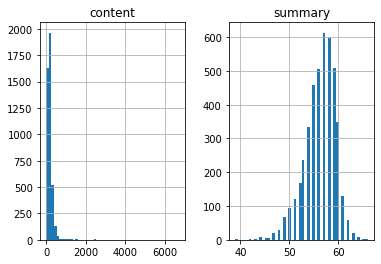

In [11]:
content_words=[]
summary_words=[]
for i in dataset['cleaned_content']:
    content_words.append(len(i.split()))
print(sorted(content_words,reverse=True))
for i in dataset['cleaned_summary']:
    summary_words.append(len(i.split()))
print(sorted(summary_words,reverse=True))
temp=pd.DataFrame({'content':content_words,'summary':summary_words})
temp.hist(bins=50)
plt.show()

In [12]:
count=0
for i in content_words:
    if i <= 500:
        count+=1
print(count/len(dataset['cleaned_content']))

0.97281732319742


In [13]:
count=0
for i in summary_words:
    if i<=60:
        count+=1
print(count/len(dataset['cleaned_summary']))

0.9497811564155725


In [0]:
max_content_length=500
max_summary_length=60

In [0]:
dataset['cleaned_summary']=dataset['cleaned_summary'].apply(lambda x:'starttok '+x+' endtok')

In [0]:
x_train,x_test,y_train,y_test = train_test_split(np.array(dataset['cleaned_content']),np.array(dataset['cleaned_summary']),test_size=0.3, random_state=0, shuffle=True)

In [17]:
x_tokenizer=Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)
print(tot_cnt-cnt)

% of rare words in vocabulary: 71.77854115995085
Total Coverage of rare words: 9.001741839113334
11255


In [0]:
x_tokenizer=Tokenizer(num_words=tot_cnt-cnt)
x_tokenizer.fit_on_texts(list(x_train))
x_train_sequences = x_tokenizer.texts_to_sequences(x_train)
x_test_sequences = x_tokenizer.texts_to_sequences(x_test)
x_train_padded=pad_sequences(x_train_sequences,maxlen=max_content_length,padding='post')
x_test_padded=pad_sequences(x_test_sequences,maxlen=max_content_length,padding='post')

In [19]:
x_vocab=(x_tokenizer.num_words)+1
print(x_vocab)

11256


In [20]:
y_tokenizer=Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))
thresh=7

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 80.35657025588405
Total Coverage of rare words: 14.21163525032339


In [0]:
y_tokenizer=Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_train))
y_train_sequences=y_tokenizer.texts_to_sequences(y_train)
y_test_sequences=y_tokenizer.texts_to_sequences(y_test)
y_train_padded=pad_sequences(y_train_sequences,maxlen=max_summary_length,padding='post')
y_test_padded=pad_sequences(y_test_sequences,maxlen=max_summary_length,padding='post')

In [22]:
y_vocab=(y_tokenizer.num_words)+1
print(y_vocab)

3064


In [23]:
y_tokenizer.word_counts['starttok'],len(y_train)

(3038, 3038)

In [0]:
ind=[]
for i in range(len(y_train_padded)):
    cnt=0
    for j in y_train_padded[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_train_padded=np.delete(y_train_padded,ind, axis=0)
x_train_padded=np.delete(x_train_padded,ind, axis=0)

ind=[]
for i in range(len(y_test_padded)):
    cnt=0
    for j in y_test_padded[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_test_padded=np.delete(y_test_padded,ind, axis=0)
x_test_padded=np.delete(x_test_padded,ind, axis=0)

In [25]:
K.clear_session()
latent_dim=256
embedding=64

encoder_inputs=Input(shape=(max_content_length,))
encoder_embed=Embedding(x_vocab,embedding,trainable=True)(encoder_inputs)
###Encoder LSTM 1
encoder_lstm1=LSTM(latent_dim,return_sequences=True, return_state=True)#, dropout=0.4)#, recurrent_dropout=0.4)
encoder_outputs1, state_h1, state_c1 = encoder_lstm1(encoder_embed)

##Encoder lstm2
encoder_lstm2=LSTM(latent_dim,return_sequences=True, return_state=True)#, dropout=0.4)#, recurrent_dropout=0.4)
encoder_outputs2, state_h2, state_c2 = encoder_lstm2(encoder_outputs1)

###Encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_sequences=True, return_state=True)#, dropout=0.4)#, recurrent_dropout=0.4)
encoder_outputs3, state_h3, state_c3 = encoder_lstm3(encoder_outputs2)

###Encoder lstm 4
encoder_lstm4=LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm4(encoder_outputs3)

####decoder part
decoder_inputs=Input(shape=(None,))

decoder_embed_layer = Embedding(y_vocab, embedding, trainable=True)
decoder_embed=decoder_embed_layer(decoder_inputs)

decoder_lstm=LSTM(latent_dim,return_sequences=True, return_state=True, dropout=0.4)#, recurrent_dropout=0.2)
decoder_outputs, decoder_forward_state, decoder_back_state = decoder_lstm(decoder_embed,initial_state=[state_h,state_c])

###Attention Layer
attention_layer=AttentionLayer(name='attention_layer')
attention_output, attention_state = attention_layer([encoder_outputs,decoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs,attention_output])
###dense layer
decoder_dense=TimeDistributed(Dense(y_vocab,activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

###Defining the model
model = Model([encoder_inputs,decoder_inputs],decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 64)      720384      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 500, 256), ( 328704      embedding[0][0]                  
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 500, 256), ( 525312      lstm[0][0]                       
______________________________________________________________________________________________

In [0]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [0]:
early_stopping=EarlyStopping(monitor='val_loss',mode='min',patience=3,verbose=1)

In [0]:
x_train_padded=np.array(x_train_padded)
y_train_padded=np.array(y_train_padded)
x_test_padded=np.array(x_test_padded)
y_test_padded=np.array(y_test_padded)

In [29]:
epochs=50
batch_size=64
history=model.fit([x_train_padded,y_train_padded[:,:-1]],
                  y_train_padded.reshape(y_train_padded.shape[0],y_train_padded.shape[1],1)[:,1:], 
                  epochs=epochs, 
                  callbacks=early_stopping, 
                  batch_size=batch_size, 
                  validation_data=([x_test_padded,y_test_padded[:,:-1]],
                                   y_test_padded.reshape(y_test_padded.shape[0],y_test_padded.shape[1],1)[:,1:]))

Epoch 1/50
48/48 [==============================] - 52s 1s/step - loss: 5.7222 - accuracy: 0.2015 - val_loss: 5.2055 - val_accuracy: 0.2401
Epoch 2/50
48/48 [==============================] - 50s 1s/step - loss: 5.3180 - accuracy: 0.2234 - val_loss: 5.1228 - val_accuracy: 0.2471
Epoch 3/50
48/48 [==============================] - 51s 1s/step - loss: 5.2329 - accuracy: 0.2355 - val_loss: 5.0320 - val_accuracy: 0.2515
Epoch 4/50
48/48 [==============================] - 51s 1s/step - loss: 5.1193 - accuracy: 0.2409 - val_loss: 4.9493 - val_accuracy: 0.2592
Epoch 5/50
48/48 [==============================] - 51s 1s/step - loss: 5.0299 - accuracy: 0.2470 - val_loss: 4.9033 - val_accuracy: 0.2650
Epoch 6/50
48/48 [==============================] - 51s 1s/step - loss: 4.9453 - accuracy: 0.2530 - val_loss: 4.8387 - val_accuracy: 0.2683
Epoch 7/50
48/48 [==============================] - 51s 1s/step - loss: 4.8540 - accuracy: 0.2580 - val_loss: 4.7434 - val_accuracy: 0.2778
Epoch 8/50
48/48 [==

In [30]:
model.save('rnn_model.h5')
from google.colab import files
files.download('rnn_model.h5')

MessageError: ignored

In [0]:
from tensorflow.keras.models import load_model
model=load_model('rnn_model.h5',custom_objects={'AttentionLayer':AttentionLayer})

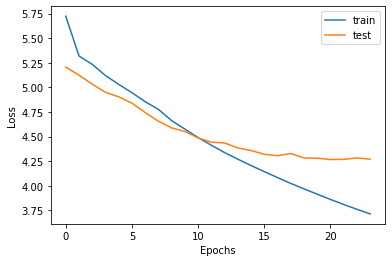

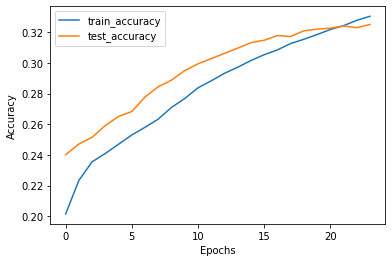

In [32]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'],label='test_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
reverse_target_index=y_tokenizer.index_word
reverse_source_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [0]:
encoder_inputs = model.input[0]
encoder_embed1=model.layers[1]
encoder_outputs, state_h, state_c = model.layers[7].output
encoder_states = [state_h,state_c]

encoder_model=Model(inputs=encoder_inputs,outputs=[encoder_outputs,state_h,state_c])

decoder_inputs = model.input[1]
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_content_length,latent_dim))
decoder_embed_layer = model.layers[6]
decoder_embed2 = decoder_embed_layer(decoder_inputs)
decoder_lstm = model.layers[8]
decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_embed2,initial_state=[decoder_state_input_h,decoder_state_input_c])

attention_layer = model.layers[9]
attention_output_inference, attention_state_inference = attention_layer([decoder_hidden_state_input,decoder_outputs])

decoder_concat_inference = Concatenate(axis=-1,name='concat')([decoder_outputs,attention_output_inference])

decoder_dense = model.layers[11]
decoder_outputs = decoder_dense(decoder_concat_inference)

decoder_model = Model([decoder_inputs]+[decoder_hidden_state_input,decoder_state_input_h,decoder_state_input_c],
                      [decoder_outputs]+[decoder_state_h,decoder_state_c])

Tensor("time_distributed_1/Identity:0", shape=(None, None, 3064), dtype=float32)


In [0]:
encoder_model=Model(inputs=encoder_inputs,outputs=[encoder_outputs,state_h,state_c])

###decoder inference
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_content_length,latent_dim))

###get the embeddings of the decoder sequence
decoder_embed2 = decoder_embed_layer(decoder_inputs)

###decoder lstm
decoder_outputs2, decoder_state_h, decoder_state_c = decoder_lstm(decoder_embed2,initial_state=[decoder_state_input_h,decoder_state_input_c])

###attention inference
attention_output_inference, attention_state_inference = attention_layer([decoder_hidden_state_input,decoder_outputs2])
###Concatenate
decoder_concat_inference = Concatenate(axis=-1,name='concat')([decoder_outputs2,attention_output_inference])

decoder_outputs2 = decoder_dense(decoder_concat_inference)

##decoder model
decoder_model = Model([decoder_inputs]+[decoder_hidden_state_input,decoder_state_input_h,decoder_state_input_c],
                      [decoder_outputs2]+[decoder_state_h,decoder_state_c])

In [0]:
def decode_sequence(input_sequence, max_length=max_summary_length):
    e_out, e_h, e_c = encoder_model.predict(input_sequence)
    target_sequence = np.zeros((1,1))
    target_sequence[0,0] = target_word_index['starttok']

    stop_condition=False
    decode_sentence=[]

    while not stop_condition:

        output_tokens, out_h, out_c = decoder_model.predict([target_sequence]+[e_out,e_h,e_c])
        
        sampled_token_index = np.argmax(output_tokens[0,-1,:])
        sampled_token  =reverse_target_index[sampled_token_index]
        if (sampled_token!='endtok'):
            decode_sentence.append(sampled_token)
        
        if (sampled_token=='endtok' or len(decode_sentence)>=(max_length-1)):
            stop_condition=True

        target_sequence = np.zeros((1,1))
        target_sequence[0,0]=sampled_token_index

        e_h,e_c = out_h, out_c

    return ' '.join(decode_sentence)

In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['starttok']) and i!=target_word_index['endtok']):
            newString=newString+reverse_target_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_index[i]+' '
    return newString

In [41]:
for i in range(0,10):
    
    print("Article:",seq2text(x_train_padded[i]))
    print("Original summary:",seq2summary(y_train_padded[i]))
    print("Predicted summary:",decode_sequence(x_train_padded[i].reshape(1,max_content_length)))
    print("\n")

Article: less hours resigned post dramatic change stance nitish kumar took oath chief minister bihar sixth time today bjp sushil modi deputy earlier lalu prasad yadav rashtriya janata dal hit streets across bihar protest nitish kumar decision dump mahagathbandhan bharatiya janata party nitish kumar walked month old grand alliance wednesday evening bringing dramatic end days political uncertainty state india today magazine nitish kumar giant nitish tendered resignation governor keshari nath tripathi governor house later night claim support mlas jd bjp take floor test assembly friday latest updates congratulations ji ji looking forward working together bihar progress prosperity scene outside raj bhawan patna preparations underway nitish kumar set sworn bihar chief minister th time today pic twitter com vehicles stuck traffic rjd supporters block mahatma gandhi connecting north bihar patna twitter com decides fight mood give without fight tejashwi yadav earlier said rjd single largest par

In [0]:
temp_data=pd.read_csv("https://raw.githubusercontent.com/Aditi2806/Articles-Dataset/master/Articles%20Dataset.csv", index_col='Heading', encoding='utf-8')
text=temp_data['Content']['How to write with artificial intelligence']
#preprocess=[i for i in text.split('.')]
test_data=x_tokenizer.texts_to_sequences([text])
test_data_padded=pad_sequences(test_data,maxlen=max_content_length,padding='post')
print(test_data_padded)
print("Article Text: ",text)
print("Generated Summary: ", decode_sequence(test_data_padded.reshape(1,max_content_length),len(text)//2))

[[  244    80  3949  2139  2449  2296  2175  3926 10879  5330  7290  1523
   1844   464   444    28  2336  1018    67   270    43   414  6471  3926
    525  4630    30  2015  4688   994  2216   108  5612  5009  9218   665
    594   701   701  4158  3341   416    36  2139  2449  1110  4863   466
   1344  2336   342   688  1318   188   536  7686   416   182   984   108
    235  1243   525  4344  8242  3010  1380  1243   633  1243   113   531
   1056  3844  4932   589  2275  4129  1006  6445  2842   388  1386  1312
   4129   184  1386  6421   388  1204  3171   350  6421  6909  1397  1386
   2668  5726  1397   139   235    64   922  1241   843  1386  5726  1397
   1397    24   235  4456  1635   235  1397  3926 10071 10879  8547  7290
   1523  1225  5726  1397   726  1225  5726  1397  1225    47   555   793
   6037  3926  5726  1397   860   156  2139  2449  6456    30  1223   147
   6445   138   291  1243   235  3765   184  3765  4129  3581   758   184
   1855  4129  1838  3765   184  2843 